# Introduction
Right from the [competition](https://www.kaggle.com/c/shelter-animal-outcomes) description:
> Every year, approximately 7.6 million companion animals end up in US shelters. Many animals are given up as unwanted by their owners, while others are picked up after getting lost or taken out of cruelty situations. Many of these animals find forever families to take them home, but just as many are not so lucky. 2.7 million dogs and cats are euthanized in the US every year. Using a dataset of intake information including breed, color, sex, and age from the Austin Animal Center, we're asking Kagglers to predict the outcome for each animal.

I will first start with processing the data and extracting some extra features and do some exploration. Then I will process the data again to train the neural network model. 

# Processing the data and extracting features

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import datetime
import calendar
import string

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [4]:
train.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.2+ MB


### Features processed
- `Name`

Based on the above, some animals have `Name` and some don't. Assuming some would prefer to adopt an animal with a name, we'll make a new feature `HasName` with `yes` and `no` categories indicating whether the animal has a name or not and remove the `Name` feature. 
- `DateTime`

`DateTime` can give us two features, `Month` and `Time` representing the month of the year and time of the day in 24 hours format, respectively.
- `OutcomeSubtype`

We're going to remove the `OutcomeSubtype` feature since the test data (see section) does not have this feature. 
- `SexuponOutcome`

`SexuponOutcome` can give us two features by spliting it up, the status of the animal, whether it is neutered, spayed..etc, and its sex. The missing data will labeled as unkown.
- `AgeuponOutcome`

`AgeuponOutcome` will be converted all to years. And we'll extract two features from it: one numeric `AgeInYears` and one categorical `StringAge` (rounded). The animals with missing ages will be removed since they are only few. 

In [6]:
def process(features):
    #fill missing OutcomeSubtype with Unkown
    features['SexuponOutcome'] = features['SexuponOutcome'].fillna('Unknown')
    #extract to new features from SexuponOutcome
    splited_SexuponOutcome = features['SexuponOutcome'].apply(lambda x: pd.Series(x.split(' ')))
    splited_SexuponOutcome.columns = ['Status', 'Gender']
    splited_SexuponOutcome = splited_SexuponOutcome.fillna('Unknown')
    features = pd.concat([features,splited_SexuponOutcome], axis=1)
    #remove rows with missing age (alternatively we can fill them with the mean)
    features = features[pd.notnull(features['AgeuponOutcome'])]
    #convert age values to float years
    splited_AgeuponOutcome = features['AgeuponOutcome'].apply(lambda x: pd.Series(x.split(' ')))
    splited_AgeuponOutcome[0] = splited_AgeuponOutcome[0].map(lambda x: float(x)) 
    for i in range(len(splited_AgeuponOutcome)):
        if splited_AgeuponOutcome.iloc[i,1]=='weeks' or splited_AgeuponOutcome.iloc[i,1]=='week':
            splited_AgeuponOutcome.iloc[i,0] = splited_AgeuponOutcome.iloc[i,0]/4
        elif splited_AgeuponOutcome.iloc[i,1]=='month' or splited_AgeuponOutcome.iloc[i,1]=='months':
            splited_AgeuponOutcome.iloc[i,0] = splited_AgeuponOutcome.iloc[i,0]/12
        elif splited_AgeuponOutcome.iloc[i,1]=='day' or splited_AgeuponOutcome.iloc[i,1]=='days':
            splited_AgeuponOutcome.iloc[i,0] = splited_AgeuponOutcome.iloc[i,0]/365
        else:
            pass
    features['AgeInYears'] = splited_AgeuponOutcome[0]
    features['SringAge'] = features['AgeInYears'].map(lambda x: str(round(x)))
    #conver date times to date time object
    features['DateTime'] = features['DateTime'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %X'))
    #create a new categorical feature rounded time of the day
    features['Time'] = features['DateTime'].map(lambda x: x.hour if x.minute <= 30 else x.hour+1)
    features['Time'] = features['Time'].map(lambda x: str(x))
    #create a new categorical feature day of the week
    features['WeekDay'] = features['DateTime'].map(lambda x: calendar.day_name[x.weekday()])
    #create a new categorical feature month of the year
    features['Month'] = features['DateTime'].map(lambda x: str(x.month))
    #create a new categorical feature whether it has a name or not
    features['HasName'] = pd.isnull(features['Name']).map(lambda x: 'yes' if not x else 'no')
    features = features.drop(['AnimalID', 'Name','SexuponOutcome', 'AgeuponOutcome','DateTime', 'OutcomeSubtype'],
                             axis=1)
    return features

In [7]:
ptrain = process(train)

In [8]:
pfeatures = ptrain.drop(['OutcomeType'],axis=1)

In [9]:
target = ptrain['OutcomeType']

In [10]:
pfeatures.head()

,AnimalType,Breed,Color,Status,Gender,AgeInYears,SringAge,Time,WeekDay,Month,HasName
0,Dog,Shetland Sheepdog Mix,Brown/White,Neutered,Male,1.00,1.0,18,Wednesday,2,yes
1,Cat,Domestic Shorthair Mix,Cream Tabby,Spayed,Female,1.00,1.0,13,Sunday,10,yes
2,Dog,Pit Bull Mix,Blue/White,Neutered,Male,2.00,2.0,12,Saturday,1,yes
3,Cat,Domestic Shorthair Mix,Blue Cream,Intact,Male,0.75,1.0,19,Friday,7,no
4,Dog,Lhasa Apso/Miniature Poodle,Tan,Neutered,Male,2.00,2.0,13,Friday,11,no


# Exploring the data

/Users/ahmadmohammad/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


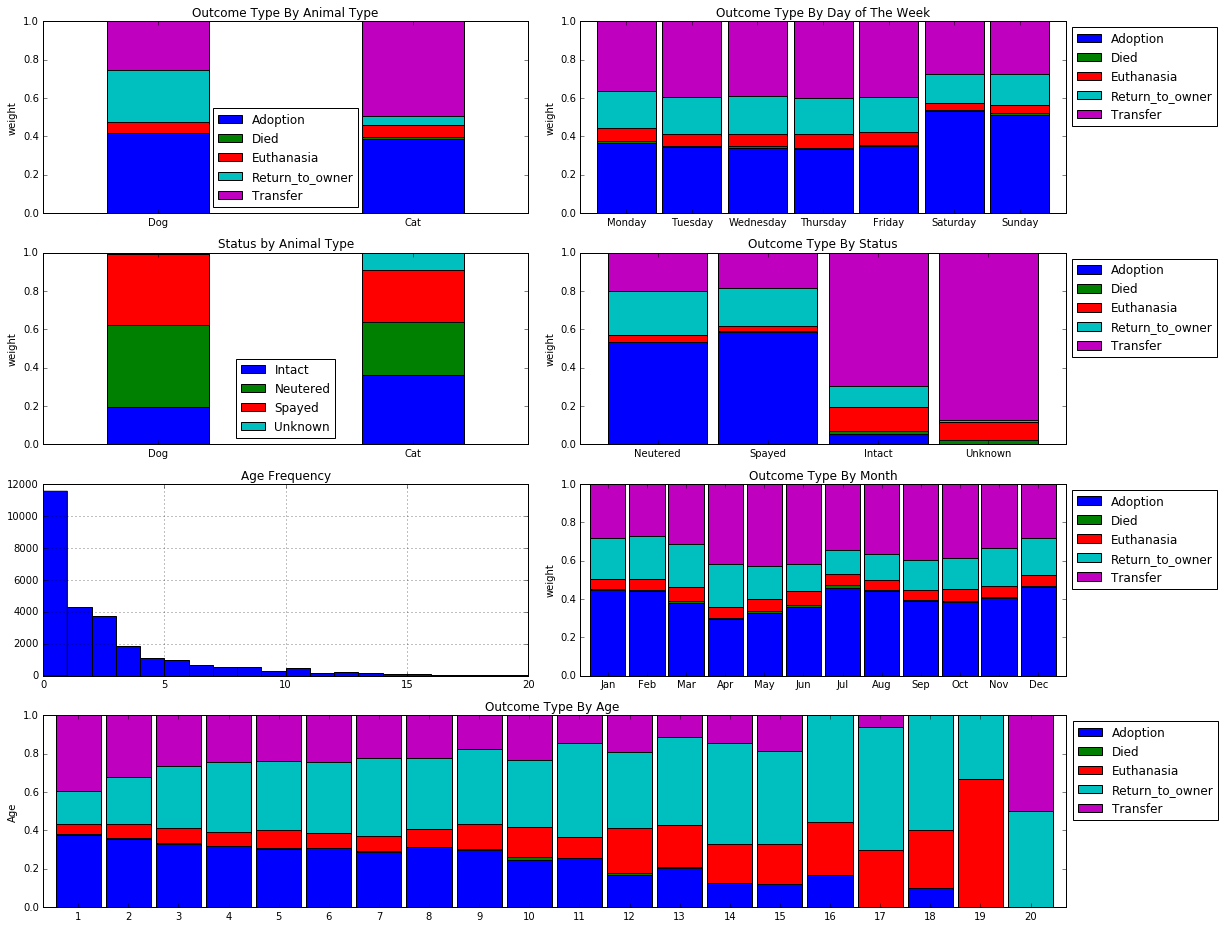

In [12]:
fig = plt.figure(figsize=(15,13), tight_layout=True)
gs = gridspec.GridSpec(4, 2)

ax1 = fig.add_subplot(gs[0,0])
out_counts = pd.concat([pd.DataFrame(ptrain[pfeatures['AnimalType']=='Dog']['OutcomeType'].value_counts()).T,
                    pd.DataFrame(ptrain[pfeatures['AnimalType']=='Cat']['OutcomeType'].value_counts()).T])
out_counts.index = ['Dog','Cat']
out_weights = out_counts.apply(lambda x: x/out_counts.sum(axis=1))
out_weights.plot(kind="bar",
                 stacked=True,
                 width=.4,
                 rot=0,
                ax=ax1)
ax1.set_title('Outcome Type By Animal Type'); ax1.set_ylabel('weight')

ax2 = fig.add_subplot(gs[0,1])
weekday_counts = pd.concat([pd.DataFrame(ptrain[ptrain['WeekDay']=='Monday']['OutcomeType'].value_counts()).T,
                            pd.DataFrame(ptrain[ptrain['WeekDay']=='Tuesday']['OutcomeType'].value_counts()).T,
                            pd.DataFrame(ptrain[ptrain['WeekDay']=='Wednesday']['OutcomeType'].value_counts()).T,
                            pd.DataFrame(ptrain[ptrain['WeekDay']=='Thursday']['OutcomeType'].value_counts()).T,
                            pd.DataFrame(ptrain[ptrain['WeekDay']=='Friday']['OutcomeType'].value_counts()).T,
                            pd.DataFrame(ptrain[ptrain['WeekDay']=='Saturday']['OutcomeType'].value_counts()).T,
                            pd.DataFrame(ptrain[ptrain['WeekDay']=='Sunday']['OutcomeType'].value_counts()).T,])
weekday_counts.index = ['Monday','Tuesday','Wednesday', 'Thursday','Friday','Saturday','Sunday']
weekday_weights = weekday_counts.apply(lambda x: x/weekday_counts.sum(axis=1))
weekday_weights.plot(kind="bar", 
                     stacked=True,
                     width=.9,
                     rot=0,
                    ax=ax2).legend(bbox_to_anchor=(1.325, 1))
ax2.set_title('Outcome Type By Day of The Week'); ax2.set_ylabel('weight')


ax3 = fig.add_subplot(gs[1,0])
status_counts = pd.concat([pd.DataFrame(pfeatures[pfeatures['AnimalType']=='Dog']['Status'].value_counts()).T,
                            pd.DataFrame(pfeatures[pfeatures['AnimalType']=='Cat']['Status'].value_counts()).T])
status_counts.index = ['Dog','Cat']
status_weights = status_counts.apply(lambda x: x/status_counts.sum(axis=1))
status_weights.plot(kind="bar", 
                    stacked=True,
                    width=.4,
                    rot=0,
                   ax=ax3)
ax3.set_title('Status by Animal Type'); ax3.set_ylabel('weight')


ax4 = fig.add_subplot(gs[1,1])
status2_counts = pd.concat([pd.DataFrame(ptrain[ptrain['Status']=='Neutered']['OutcomeType'].value_counts()).T,
                            pd.DataFrame(ptrain[ptrain['Status']=='Spayed']['OutcomeType'].value_counts()).T,
                            pd.DataFrame(ptrain[ptrain['Status']=='Intact']['OutcomeType'].value_counts()).T,
                            pd.DataFrame(ptrain[ptrain['Status']=='Unknown']['OutcomeType'].value_counts()).T])
status2_counts.index = list(ptrain['Status'].unique())
status2_weights = status2_counts.apply(lambda x: x/status2_counts.sum(axis=1))
status2_weights.plot(kind="bar", 
                     stacked=True,
                     width=.9,
                     rot=0,
                    ax=ax4).legend(bbox_to_anchor=(1.325, 1))
ax4.set_title('Outcome Type By Status'); ax4.set_ylabel('weight')


ax5 = fig.add_subplot(gs[2,0])
pfeatures.hist(column="AgeInYears",       
               color="blue",
               bins=20,
              ax=ax5) 
ax5.set_title('Age Frequency')


ax6 = fig.add_subplot(gs[2,1])
month_counts = pd.DataFrame(ptrain[ptrain['Month']=='1']['OutcomeType'].value_counts()).T
for i in range(2,13):
    month_counts = pd.concat([month_counts,
                              pd.DataFrame(ptrain[ptrain['Month']==str(i)]['OutcomeType'].value_counts()).T])
month_counts.index = ['Jan','Feb','Mar', 'Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_weights = month_counts.apply(lambda x: x/month_counts.sum(axis=1))
month_weights.plot(kind="bar", 
                     stacked=True,
                     width=.9,
                     rot=0,
                    ax=ax6).legend(bbox_to_anchor=(1.325, 1))
ax6.set_title('Outcome Type By Month'); ax6.set_ylabel('weight')


ax7 = fig.add_subplot(gs[3,0:])
AgeInYears_counts = pd.DataFrame(ptrain[ptrain['AgeInYears']==1]['OutcomeType'].value_counts()).T
for i in range(2,21):
    AgeInYears_counts = pd.concat([AgeInYears_counts,
                                   pd.DataFrame(ptrain[ptrain['AgeInYears']==i]['OutcomeType'].value_counts()).T])
AgeInYears_counts.index = range(1,21)
AgeInYears_weights = AgeInYears_counts.apply(lambda x: x/AgeInYears_counts.sum(axis=1))
AgeInYears_weights.plot(kind="bar", 
                     stacked=True,
                     width=.9,
                     rot=0,
                    ax=ax7).legend(bbox_to_anchor=(1.155,1))
ax7.set_title('Outcome Type By Age '); ax7.set_ylabel('Age')




I'm going to let the charts speak for themselves. But for a quick highlights:
- the majority of the adopted are either neutered or spayed.
- Most of the adoption happens on the weekends.
- Cats are more likely to be transferred than dogs (animal racism #PETA)
- The majority of the animals are within the age of few months to one year. 
- Older animals are more likely to be returned to owner or get Youth In Asia and younger ones are more likely to be adopted. 


# Training the model

All of the data are categorical except for the age (the time can be treated as numeric but i got a better score as categorical). So we'll binarize the categorical features to prepare them for training by pandas `get_dummies`.

In [13]:
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0            
        if col_data.dtype == object:  # or col_data.dtype == 'category':
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

In [14]:
x_train = preprocess_features(pfeatures)

### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegressionCV
log = LogisticRegressionCV()
model_log = log.fit(x_train,target)

### Random Forests

In [16]:
from sklearn.ensemble import RandomForestClassifier
ran = RandomForestClassifier(5000)
model_rf = ran.fit(x_train,target)

### Neural Networks
Since sklearn current version does not have the neural network model, we'll use google's tensor flow. Tensor flow does not accept pandas table so we'll convert them to numpy matrix and encode the target labels. 

In [ ]:
from tensorflow.contrib import learn
from sklearn import preprocessing

#conver the data to numpy matrix and encoding the target labels
columns = list(target.unique())
columns.sort()
le = preprocessing.LabelEncoder()
le.fit(columns)
target_enc = le.transform(target.values) 
x_train_np = x_train.as_matrix()


model_nn = learn.TensorFlowDNNClassifier(hidden_units=[100], n_classes=5, steps=5000)
model_nn.fit(x_train_np, target_enc)

# Testing the model
Before testing the model, let's quickly calculate the accuracy score on the train set for each model. 

In [18]:
model_log.score(x_train, target)

0.68713264198270374

In [19]:
model_rf.score(x_train, target)

0.99816554977350158

In [20]:
model_nn.score(x_train_np, target_enc)

0.71127999700497924

And now we'll process the features of the test data.

In [21]:
test = pd.read_csv('test.csv')

In [22]:
test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


In [23]:
def process_t(features):
    #split SexuponOutcome columns and add it to features
    splited_SexuponOutcome = features['SexuponOutcome'].apply(lambda x: pd.Series(x.split(' ')))
    splited_SexuponOutcome.columns = ['Status', 'Gender']
    #splited_SexuponOutcome = splited_SexuponOutcome.fillna('Unknown')
    features = pd.concat([features,splited_SexuponOutcome], axis=1)
    #convert the age to years of type float    
    features['AgeuponOutcome'] = features['AgeuponOutcome'].fillna('2.2 years')
    splited_AgeuponOutcome = features['AgeuponOutcome'].apply(lambda x: pd.Series(x.split(' ')))
    splited_AgeuponOutcome[0] = splited_AgeuponOutcome[0].map(lambda x: float(x)) #if x != "Unknown" else None)
    for i in range(len(splited_AgeuponOutcome)):
        if splited_AgeuponOutcome.iloc[i,1]=='weeks' or splited_AgeuponOutcome.iloc[i,1]=='week':
            splited_AgeuponOutcome.iloc[i,0] = splited_AgeuponOutcome.iloc[i,0]/4
        elif splited_AgeuponOutcome.iloc[i,1]=='month' or splited_AgeuponOutcome.iloc[i,1]=='months':
            splited_AgeuponOutcome.iloc[i,0] = splited_AgeuponOutcome.iloc[i,0]/12
        elif splited_AgeuponOutcome.iloc[i,1]=='day' or splited_AgeuponOutcome.iloc[i,1]=='days':
            splited_AgeuponOutcome.iloc[i,0] = splited_AgeuponOutcome.iloc[i,0]/365
        else:
            pass
    features['AgeInYears'] = splited_AgeuponOutcome[0]
    features['SringAge'] = features['AgeInYears'].map(lambda x: str(round(x)))
    features['DateTime'] = features['DateTime'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %X'))
    features['Time'] = features['DateTime'].map(lambda x: x.hour if x.minute <= 30 else x.hour+1)
    features['Time'] = features['Time'].map(lambda x: str(x))
    features['WeekDay'] = features['DateTime'].map(lambda x: calendar.day_name[x.weekday()])
    features['Month'] = features['DateTime'].map(lambda x: str(x.month))
    features['HasName'] = pd.isnull(features['Name']).map(lambda x: 'yes' if not x else 'no')
    features = features.drop(['ID', 'Name','SexuponOutcome', 'AgeuponOutcome', 'DateTime'],  axis=1)
    return features

In [24]:
ptest = process_t(test)

In [25]:
x_test = preprocess_features(ptest)

Because there are some subfeeatures in the train data that are not in the test data and vise verca, the two will have different columns. Thanks to [this](http://stackoverflow.com/questions/34170413/possible-ways-to-do-one-hot-encoding-in-scikit-learn) answer on stackoverflow, the problem is resolved by the code below:

In [26]:
col_to_add = np.setdiff1d(x_train.columns, x_test.columns)
for c in col_to_add:
    x_test[c] = 0
x_test = x_test[x_train.columns]

In [27]:
# converting to numpy for the nueral networks model
x_test_np = x_test.as_matrix()

In [28]:
def submit(test_data, model, name):
    df = pd.DataFrame(data=model.predict_proba(test_data), columns=columns)
    submission = pd.DataFrame({'ID':test['ID'].values})
    final = pd.concat([submission, df], axis=1)
    final.to_csv(''.join([name,'.csv']), index=False)

In [29]:
submit(x_test, model_log, 'logistic_regression')

In [30]:
submit(x_test, model_rf, 'random_forests')

In [31]:
submit(x_test_np, model_nn,'neural_networks')

# Results and Conclusion
| Model               | Test Score on Kaggle (lower is better) |
|---------------------|------------|
| Logistic Regression | 0.85446    |
| Random Forests      | 0.79586    |
| Neural Networks     | 0.77518    |

Note that for random forests and neural networks I tried a bunch of parameters on the test (number of trees for random forests and hidden units, layers, regularization penalty and steps for neural networks) set to get the best results  . However, this is not the correct way in the real world. The parameters should be tuned based on cross validation on the training set. Sklearm's `LogisticRegressionCV` already does the fine-tuning so didn't need to play with the parameters for the logistic regression model. 